In [ ]:
import os
import shutil
import random
import csv

def split_dataset(
    input_dir,
    output_dir,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    seed=42,
    save_split=True
):

    # Ensure ratios sum to 1.0 (or very close)
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1."

    # Create the output directories for train, val, test
    split_names = ['train', 'val', 'test']
    class_names = [d for d in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, d))]

    for split_name in split_names:
        split_path = os.path.join(output_dir, split_name)
        os.makedirs(split_path, exist_ok=True)
        # Create subfolders for each class
        for class_name in class_names:
            os.makedirs(os.path.join(split_path, class_name), exist_ok=True)

    # Collect filenames for each class
    data_splits = []  # for saving to CSV: list of (filename, class, subset)
    random.seed(seed)

    for class_name in class_names:
        class_path = os.path.join(input_dir, class_name)
        all_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        # Shuffle the files to ensure random split
        random.shuffle(all_files)

        # Compute split indices
        total = len(all_files)
        train_end = int(train_ratio * total)
        val_end = int((train_ratio + val_ratio) * total)

        train_files = all_files[:train_end]
        val_files = all_files[train_end:val_end]
        test_files = all_files[val_end:]

        # Helper to move files to the correct subfolder
        def copy_files(file_list, split_name):
            for fname in file_list:
                src = os.path.join(class_path, fname)
                dst = os.path.join(output_dir, split_name, class_name, fname)
                shutil.copy2(src, dst)  # or shutil.move(src, dst)
                if save_split:
                    data_splits.append((fname, class_name, split_name))

        # Copy files to output directories
        copy_files(train_files, 'train')
        copy_files(val_files, 'val')
        copy_files(test_files, 'test')

    # Optionally save the split details
    if save_split:
        csv_path = os.path.join(output_dir, "dataset_split.csv")
        with open(csv_path, mode='w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(["filename", "class", "subset"])
            writer.writerows(data_splits)

        print(f"Split details saved to: {csv_path}")

    print("Dataset successfully split into train/val/test.")

In [ ]:
input_dir = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/spectrograms_averaged"
output_dir = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/spectrograms_averaged_split"

split_dataset(
    input_dir=input_dir,
    output_dir=output_dir,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    seed=42,
    save_split=True
)

Split details saved to: /content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/spectrograms_averaged_split/dataset_split.csv
Dataset successfully split into train/val/test.


In [ ]:
import os

split_dir = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/spectrograms_averaged_split"

for split in ['train', 'val', 'test']:
    split_path = os.path.join(split_dir, split)
    print(f"Split: {split}")
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        num_files = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
        print(f"  Class: {class_name} - {num_files} files")


Split: train
  Class: normal - 27 files
  Class: schizophrenia - 31 files
Split: val
  Class: normal - 6 files
  Class: schizophrenia - 7 files
Split: test
  Class: normal - 6 files
  Class: schizophrenia - 7 files


In [ ]:
input_dir = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/spectrograms_RGB"
output_dir = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/spectrograms_RGB_split"

split_dataset(
    input_dir=input_dir,
    output_dir=output_dir,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    seed=42,
    save_split=True
)

Split details saved to: /content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/spectrograms_RGB_split/dataset_split.csv
Dataset successfully split into train/val/test.


In [ ]:
import os
import shutil
import random

def split_subject_folders(
    input_dir,
    output_dir,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    seed=42
):
    """
    Splits subject subfolders into train, val, and test sets,
    keeping all channel images for a subject together.

    Directory structure assumption:
        input_dir/
            normal/
                subject_001/
                    channel_1.png
                    ...
                    channel_16.png
                subject_002/
                    ...
            schizophrenia/
                subject_003/
                    ...
                ...
    """

    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1."

    random.seed(seed)

    # Classes (e.g. 'normal', 'schizophrenia')
    class_names = [
        d for d in os.listdir(input_dir)
        if os.path.isdir(os.path.join(input_dir, d))
    ]

    for split_name in ['train', 'val', 'test']:
        split_path = os.path.join(output_dir, split_name)
        os.makedirs(split_path, exist_ok=True)
        # Make subfolders for each class
        for class_name in class_names:
            os.makedirs(os.path.join(split_path, class_name), exist_ok=True)

    # For each class, gather subject subfolders, shuffle, and split
    for class_name in class_names:
        class_path = os.path.join(input_dir, class_name)

        # Each 'subject_XXX' folder is a single data unit
        subject_folders = [
            f for f in os.listdir(class_path)
            if os.path.isdir(os.path.join(class_path, f))
        ]
        random.shuffle(subject_folders)

        total = len(subject_folders)
        train_end = int(train_ratio * total)
        val_end = int((train_ratio + val_ratio) * total)

        train_subjects = subject_folders[:train_end]
        val_subjects = subject_folders[train_end:val_end]
        test_subjects = subject_folders[val_end:]

        def copy_subjects(subject_list, split_name):
            for subj in subject_list:
                src_folder = os.path.join(class_path, subj)
                dst_folder = os.path.join(output_dir, split_name, class_name, subj)
                shutil.copytree(src_folder, dst_folder)

        copy_subjects(train_subjects, 'train')
        copy_subjects(val_subjects, 'val')
        copy_subjects(test_subjects, 'test')

    print("Split complete. Subject folders have been moved to train/val/test.")


In [ ]:
# Example usage
input_dir = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/16_spectrograms"
output_dir = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/16_spectrograms_split"

split_subject_folders(input_dir, output_dir)

Split complete. Subject folders have been moved to train/val/test.


# Average

## CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping

# Directories
train_dir = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/spectrograms_averaged_split/train"
val_dir = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/spectrograms_averaged_split/val"
save_path = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/CNN/avg.keras"

# Parameters
img_height, img_width = 224, 224
batch_size = 32

# Data generators (rescaling to [0,1])
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_dir, target_size=(img_height, img_width),
    batch_size=batch_size, class_mode='sparse'
)
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir, target_size=(img_height, img_width),
    batch_size=batch_size, class_mode='sparse'
)

# Define a small CNN model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(2, activation="softmax")
])

model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping callback
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

# Train the model for 60 epochs with early stopping
history = model.fit(
    train_gen,
    epochs=60,
    validation_data=val_gen,
    callbacks=callbacks
)

# Save the model
model.save(save_path)
print(f"Model saved to {save_path}")


Found 58 images belonging to 2 classes.
Found 13 images belonging to 2 classes.
Epoch 1/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4562 - loss: 7.7097 - val_accuracy: 0.5385 - val_loss: 4.8320
Epoch 2/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step - accuracy: 0.4102 - loss: 5.2709 - val_accuracy: 0.4615 - val_loss: 1.9002
Epoch 3/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 419ms/step - accuracy: 0.4642 - loss: 1.6018 - val_accuracy: 0.5385 - val_loss: 0.9349
Epoch 4/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step - accuracy: 0.5486 - loss: 0.9261 - val_accuracy: 0.5385 - val_loss: 0.8600
Epoch 5/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step - accuracy: 0.5102 - loss: 0.8767 - val_accuracy: 0.5385 - val_loss: 0.6951
Epoch 6/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step - accuracy: 0.5647 - loss: 0.6834 - val_accuracy: 0.4615 - val_loss: 0.6922
Epoch 7/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step - accuracy: 0.4757 - loss: 0.6849 - val_accuracy: 0.4615 - val_loss: 0.6931
Epoch 8/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 40

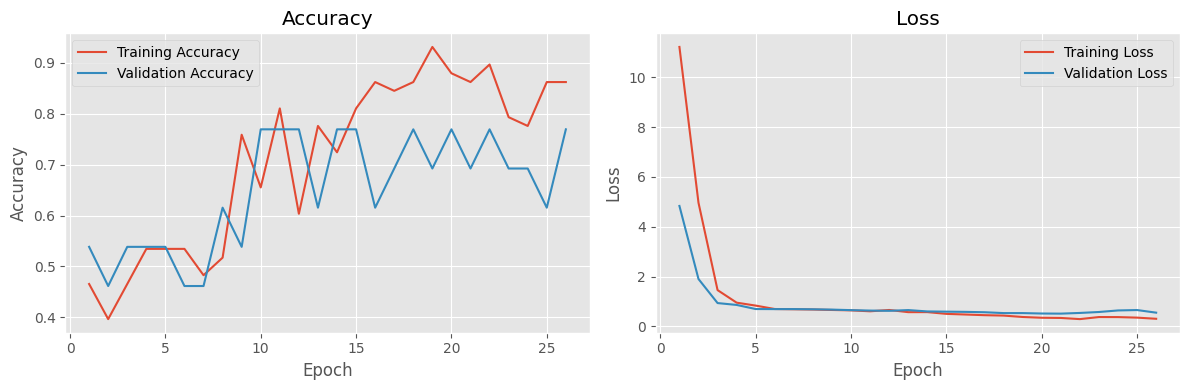

In [ ]:
import matplotlib.pyplot as plt

# Use an available style, e.g., 'ggplot'
plt.style.use('ggplot')

epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
axs[0].plot(epochs, acc, color='C0', label='Training Accuracy')
axs[0].plot(epochs, val_acc, color='C1', label='Validation Accuracy')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Loss plot
axs[1].plot(epochs, loss, color='C0', label='Training Loss')
axs[1].plot(epochs, val_loss, color='C1', label='Validation Loss')
axs[1].set_title('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
simple_model = keras.models.load_model('/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/average_model/CNN.keras')
batch_size = 128
img_height = 224
img_width = 224
test_path = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/spectrograms_averaged_split/test"

# Load test dataset from test directory
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Get class names
class_names = train_ds.class_names
print(class_names)


# First, get predictions on test dataset
y_pred = []
y_true = []

# Get true labels and predictions
for images, labels in test_ds:
    # Get predictions for this batch
    predictions = simple_model.predict(images, verbose=0)
    pred_classes = np.argmax(predictions, axis=1)

    # Store predictions and true labels
    y_pred.extend(pred_classes)
    y_true.extend(labels.numpy())

# Convert to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

Found 13 files belonging to 2 classes.
['norm', 'sch']


Test Accuracy: 0.7692
Precision: 0.7738
Recall: 0.7143
F1 Score: 0.7692


<Figure size 1000x800 with 0 Axes>

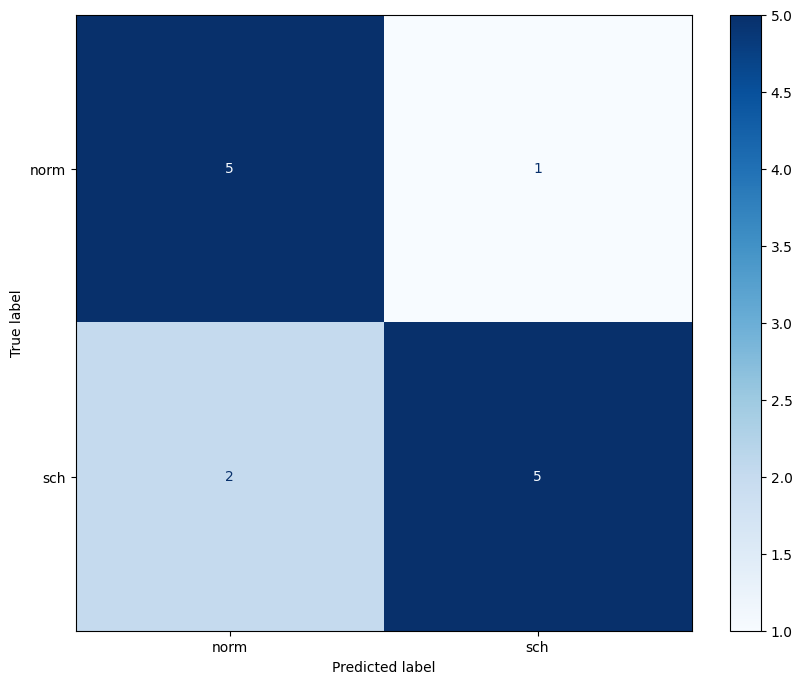

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d', ax=ax)
ax.grid(False)  # Turn off the grid

# Calculate metrics
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

## RGB

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Directories and parameters
train_dir = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/spectrograms_RGB_split/train"
val_dir = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/spectrograms_RGB_split/val"
save_path = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/CNN/rgb.keras"
img_height, img_width = 224, 224
batch_size = 32

# Data generators
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
).flow_from_directory(
    train_dir, target_size=(img_height, img_width),
    batch_size=batch_size, class_mode='sparse'
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir, target_size=(img_height, img_width),
    batch_size=batch_size, class_mode='sparse'
)

# CNN model with regularization
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.1),  # Reduced dropout
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.1),  # Reduced dropout
    layers.Flatten(),
    layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),  # Reduced L2
    layers.Dropout(0.2),  # Reduced dropout
    layers.Dense(2, activation="softmax")
])

# Compile and train
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),  # 100x larger learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_gen, epochs=60,
    validation_data=val_gen,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

model.save(save_path)
print(f"Model saved to {save_path}")

Found 58 images belonging to 2 classes.
Found 13 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 18s/step - accuracy: 0.4447 - loss: 5.5676 - val_accuracy: 0.5385 - val_loss: 1.6644
Epoch 2/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step - accuracy: 0.4666 - loss: 3.3699 - val_accuracy: 0.4615 - val_loss: 0.7614
Epoch 3/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step - accuracy: 0.4169 - loss: 1.4886 - val_accuracy: 0.4615 - val_loss: 0.8379
Epoch 4/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step - accuracy: 0.4527 - loss: 0.8882 - val_accuracy: 0.5385 - val_loss: 0.7113
Epoch 5/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step - accuracy: 0.6317 - loss: 0.7426 - val_accuracy: 0.5385 - val_loss: 0.7106
Epoch 6/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step - accuracy: 0.5427 - loss: 0.7332 - val_accuracy: 0.5385 - val_loss: 0.7124
Epoch 7/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step - accuracy: 0.5115 - loss: 0.7070 - val_accuracy: 0.5385 - val_loss: 0.7144
Epoch 8/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step - accuracy: 0.5358 - loss: 0.7099 - val_accuracy: 0.5385 - val_loss: 

In [ ]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
import glob
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def load_multichannel_data(base_folder, img_size=(224, 224)):
    X, y = [], []
    class_folders = [d for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))]

    for class_idx, class_name in enumerate(sorted(class_folders)):
        class_path = os.path.join(base_folder, class_name)
        subject_folders = [d for d in os.listdir(class_path) if os.path.isdir(os.path.join(class_path, d))]

        for subject in subject_folders:
            subject_path = os.path.join(class_path, subject)
            channel_files = glob.glob(os.path.join(subject_path, "channel_*.png"))

            if len(channel_files) > 0:
                channel_files.sort()
                channels = []
                for channel_file in channel_files:
                    img = Image.open(channel_file).convert('L')
                    img = img.resize(img_size)
                    channels.append(np.array(img))

                if len(channels) > 0:
                    multichannel_img = np.stack(channels, axis=-1)
                    X.append(multichannel_img)
                    y.append(class_idx)

    return np.array(X), np.array(y)

# Directories
base_dir = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/16_spectrograms_split"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")     # Using dedicated val folder
test_dir = os.path.join(base_dir, "test")   # Keeping test separate
save_path = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/CNN/16channel_model.keras"

# Load all datasets
X_train, y_train = load_multichannel_data(train_dir)
X_val, y_val = load_multichannel_data(val_dir)
X_test, y_test = load_multichannel_data(test_dir)

print(f"Training data shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Labels: {y_test.shape}")

Training data shape: (58, 224, 224, 16), Labels: (58,)
Validation data shape: (13, 224, 224, 16), Labels: (13,)
Test data shape: (13, 224, 224, 16), Labels: (13,)


In [ ]:
# Data normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Get number of channels
num_channels = X_train.shape[-1]
print(f"Number of channels: {num_channels}")

# Build model
model = models.Sequential([
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                 input_shape=(224, 224, num_channels)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Classification head
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # Assuming 2 classes
])

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
]

# Train
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

# Save model
model.save(save_path)
print(f"Model saved to {save_path}")

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

Number of channels: 16


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5749 - loss: 1.4568 - val_accuracy: 0.5385 - val_loss: 0.6813 - learning_rate: 1.0000e-04
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8248 - loss: 0.4546 - val_accuracy: 0.5385 - val_loss: 0.6752 - learning_rate: 1.0000e-04
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9370 - loss: 0.2043 - val_accuracy: 0.4615 - val_loss: 0.6903 - learning_rate: 1.0000e-04
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9481 - loss: 0.1718 - val_accuracy: 0.4615 - val_loss: 0.7210 - learning_rate: 1.0000e-04
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9266 - loss: 0.2095 - val_accuracy: 0.4615 - val_loss: 0.7610 - learning_rate: 1.0000e-04
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9578 - loss: 0.1201 - val_accuracy: 0.4615 - val_loss: 0.8238 - learning_rate: 1.0000e-04
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9914 - loss: 0.0952


# 12Segmentation

In [ ]:
input_dir = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/12_segmentation"
output_dir = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/12_segmentation_split"

split_dataset(
    input_dir=input_dir,
    output_dir=output_dir,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    seed=42,
    save_split=True
)

# New Section

## CNN

In [ ]:
import os
import cv2
import glob
import pathlib
import PIL, PIL.Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from pathlib import Path

In [ ]:
a_dataset = Path("/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/12_segmentation")

In [ ]:
image_count = len(list(a_dataset.glob('*/*.png')))

In [ ]:
image_count

516

In [ ]:
batch_size = 128
img_height = 224
img_width = 224

# Update dataset paths to use the split directories
train_path = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/12_segmentation_split/train"
val_path = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/12_segmentation_split/val"
test_path = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/12_segmentation_split/test"

# Load training dataset from train directory
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Load validation dataset from val directory
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Load test dataset from test directory
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Get class names
class_names = train_ds.class_names
print(class_names)

Found 361 files belonging to 2 classes.
Found 77 files belonging to 2 classes.
Found 78 files belonging to 2 classes.
['norm', 'sch']


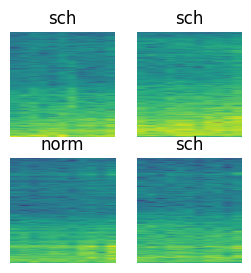

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128,)


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = len(class_names)

simple_model = tf.keras.Sequential([
  layers.Conv2D(32, 3, activation='relu'),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.Conv2D(128, 3, activation='relu'),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])
opt = keras.optimizers.Adam(learning_rate=0.0001)
simple_model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


history = simple_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=60)

Epoch 1/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 76s 16s/step - accuracy: 0.5868 - loss: 0.6917 - val_accuracy: 0.5844 - val_loss: 0.6837
Epoch 2/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step - accuracy: 0.5868 - loss: 0.6826 - val_accuracy: 0.5844 - val_loss: 0.6793
Epoch 3/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step - accuracy: 0.5868 - loss: 0.6814 - val_accuracy: 0.5844 - val_loss: 0.6795
Epoch 4/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step - accuracy: 0.5868 - loss: 0.6779 - val_accuracy: 0.5844 - val_loss: 0.6791
Epoch 5/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step - accuracy: 0.5868 - loss: 0.6785 - val_accuracy: 0.5844 - val_loss: 0.6800
Epoch 6/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step - accuracy: 0.5868 - loss: 0.6794 - val_accuracy: 0.5844 - val_loss: 0.6794
Epoch 7/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step - accuracy: 0.5868 - loss: 0.6787 - val_accuracy: 0.5844 - val_loss: 0.6784
Epoch 8/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step - accuracy: 0.5868 - loss: 0.6778 - val_accuracy: 0.5844 - val_loss: 

In [ ]:
simple_model.save('/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/segm_model/segmentation_cnn.keras')

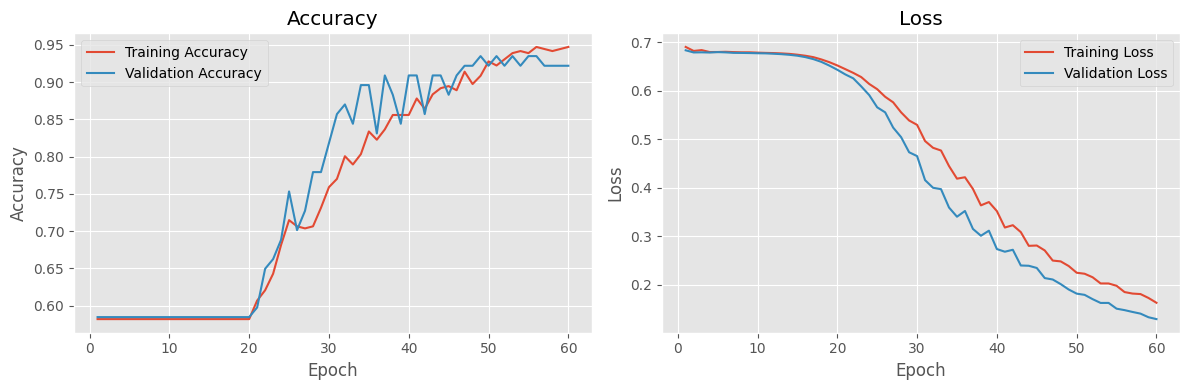

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Extract accuracy and loss values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# 3. Plot training curves
plt.style.use('ggplot')
epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
axs[0].plot(epochs, acc, color='C0', label='Training Accuracy')
axs[0].plot(epochs, val_acc, color='C1', label='Validation Accuracy')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Loss plot
axs[1].plot(epochs, loss, color='C0', label='Training Loss')
axs[1].plot(epochs, val_loss, color='C1', label='Validation Loss')
axs[1].set_title('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


Test Accuracy: 0.9487
Precision: 0.9592
Recall: 1.0000
F1 Score: 0.9574


<Figure size 1000x800 with 0 Axes>

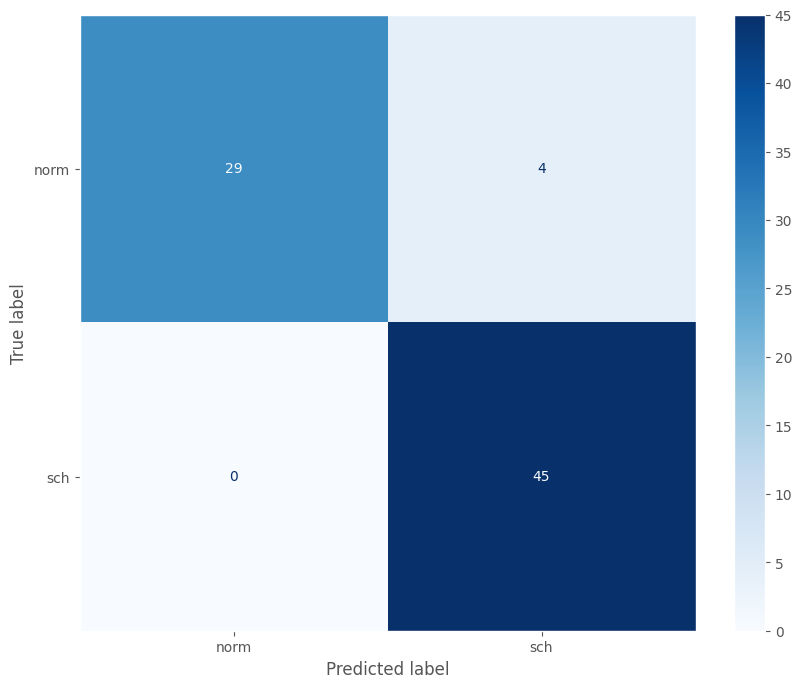

In [ ]:

simple_model = keras.models.load_model('/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/segm_model/segmentation_cnn.keras')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# First, get predictions on test dataset
y_pred = []
y_true = []

# Get true labels and predictions
for images, labels in test_ds:
    # Get predictions for this batch
    predictions = simple_model.predict(images, verbose=0)
    pred_classes = np.argmax(predictions, axis=1)

    # Store predictions and true labels
    y_pred.extend(pred_classes)
    y_true.extend(labels.numpy())

# Convert to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d', ax=ax)
ax.grid(False)  # Turn off the grid

# Calculate metrics
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 16 channels

In [ ]:
import os
import cv2
import glob
import pathlib
import PIL, PIL.Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from pathlib import Path
batch_size = 128
img_height = 224
img_width = 224

# Update dataset paths to use the split directories
train_path = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/16_spectrograms_split/train"
val_path = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/16_spectrograms_split/val"
test_path = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/16_spectrograms_split/test"

# Load training dataset from train directory
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Load validation dataset from val directory
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Load test dataset from test directory
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Get class names
class_names = train_ds.class_names
print(class_names)

Found 928 files belonging to 2 classes.
Found 208 files belonging to 2 classes.
Found 208 files belonging to 2 classes.
['normal', 'schizophrenia']


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = len(class_names)

simple_model = tf.keras.Sequential([
  layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Conv2D(64, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.Conv2D(64, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),

  layers.Conv2D(128, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.Conv2D(128, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.Conv2D(128, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.Dropout(0.5),
  layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])

opt = keras.optimizers.Adam(learning_rate=0.0001)
simple_model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = simple_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=200,
  callbacks=[early_stopping]
)

Epoch 1/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 498s 57s/step - accuracy: 0.5343 - loss: 2.7100 - val_accuracy: 0.5385 - val_loss: 2.6371
Epoch 2/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - accuracy: 0.5429 - loss: 2.6136 - val_accuracy: 0.5385 - val_loss: 2.5463
Epoch 3/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 339ms/step - accuracy: 0.5337 - loss: 2.5246 - val_accuracy: 0.5385 - val_loss: 2.4582
Epoch 4/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 364ms/step - accuracy: 0.5561 - loss: 2.4364 - val_accuracy: 0.5385 - val_loss: 2.3735
Epoch 5/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step - accuracy: 0.5582 - loss: 2.3520 - val_accuracy: 0.5385 - val_loss: 2.2925
Epoch 6/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 0.5498 - loss: 2.2723 - val_accuracy: 0.5385 - val_loss: 2.2156
Epoch 7/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step - accuracy: 0.5535 - loss: 2.1965 - val_accuracy: 0.5385 - val_loss: 2.1430
Epoch 8/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 349ms/step - accuracy: 0.5453 - loss: 2.1237 - val_accuracy: 0.5385 - val_loss:

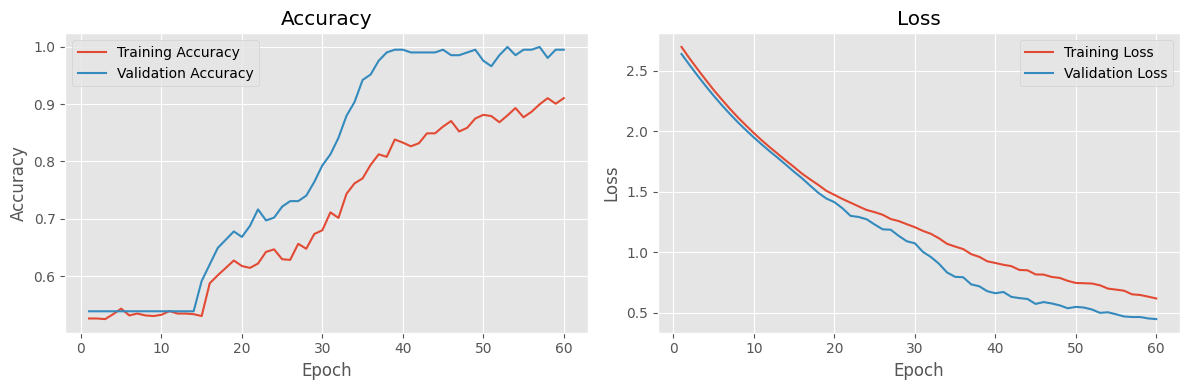

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Extract accuracy and loss values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# 3. Plot training curves
plt.style.use('ggplot')
epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
axs[0].plot(epochs, acc, color='C0', label='Training Accuracy')
axs[0].plot(epochs, val_acc, color='C1', label='Validation Accuracy')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Loss plot
axs[1].plot(epochs, loss, color='C0', label='Training Loss')
axs[1].plot(epochs, val_loss, color='C1', label='Validation Loss')
axs[1].set_title('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
simple_model.save('/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/16_model/16_cnn.keras')

Test Accuracy: 0.9567
Precision: 0.9571
Recall: 0.9196
F1 Score: 0.9581


<Figure size 1000x800 with 0 Axes>

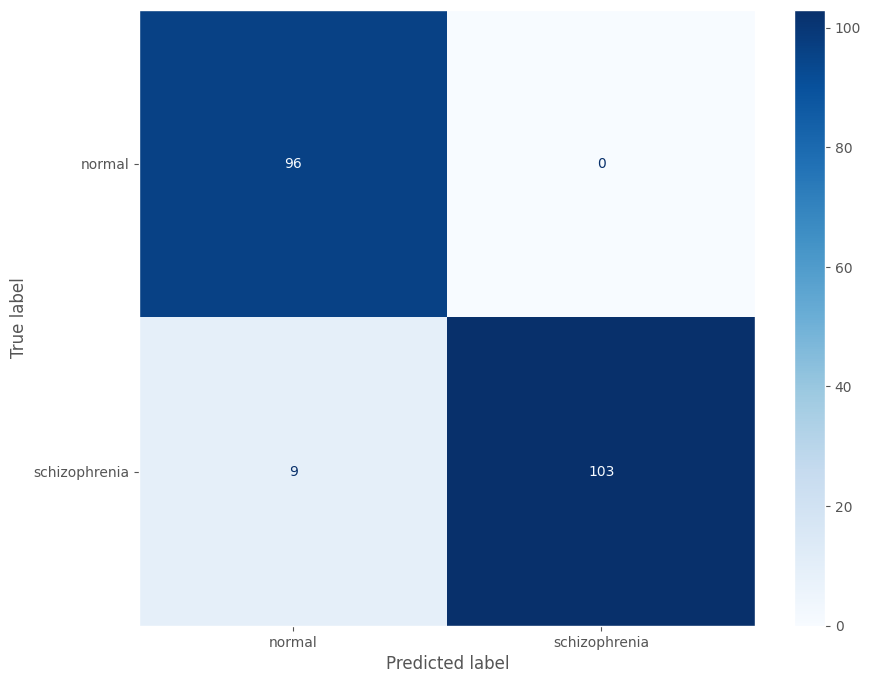

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
simple_model = keras.models.load_model('/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/16_model/16_cnn.keras')

# First, get predictions on test dataset
y_pred = []
y_true = []

# Get true labels and predictions
for images, labels in test_ds:
    # Get predictions for this batch
    predictions = simple_model.predict(images, verbose=0)
    pred_classes = np.argmax(predictions, axis=1)

    # Store predictions and true labels
    y_pred.extend(pred_classes)
    y_true.extend(labels.numpy())

# Convert to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d', ax=ax)
ax.grid(False)  # Turn off the grid

# Calculate metrics
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Multitaper method with XGBoost

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/tabular/eeg_features_multitaper.csv')

# Separate features and labels
X = data.drop('label', axis=1).values
y = data['label'].values

print(f"Loaded features shape: {X.shape}")
print(f"Loaded labels shape: {y.shape}")
print(f"Class distribution: {np.bincount(y)}")

Loaded features shape: (6720, 49)
Loaded labels shape: (6720,)
Class distribution: [3120 3600]


In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)


In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Important: The fundamental issue is that RandomizedSearchCV doesn't properly pass early_stopping_rounds
# to XGBoost models when using sklearn's API. We have two solutions:

# SOLUTION 1: Two-stage approach - first do hyperparameter tuning, then apply early stopping to the best model
# This is a clean approach that separates the concerns

# 1) prepare model
xgb_model = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,    # avoid legacy warnings
    verbosity=0,                # suppress training logs
    tree_method='gpu_hist' if gpu_available else 'hist',
    predictor='gpu_predictor' if gpu_available else 'auto',
    n_jobs=-1,
)

# 2) smaller search via RandomizedSearchCV - WITHOUT early stopping
rand_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions={
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 1.0],
        # keep n_estimators moderate since we're not using early stopping here
        'n_estimators': [100, 200],
    },
    n_iter=30,                          # only 30 sampled configs
    scoring='accuracy',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1,
    return_train_score=True,
)

# Fit without early stopping for hyperparameter tuning
rand_search.fit(X_train, y_train)

print("Best params:", rand_search.best_params_)
print("CV acc:", rand_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
CV acc: 0.9279069767441861


In [ ]:
# Get best parameters from RandomizedSearchCV
best_params = rand_search.best_params_

final_model = xgb.XGBClassifier(
    # **best_params,
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=7,
    subsample=1,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    verbosity=0,
    tree_method='gpu_hist' if gpu_available else 'hist',
    predictor='gpu_predictor' if gpu_available else 'auto',
    n_jobs=-1,
    early_stopping_rounds = 20
)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],        # your hold-out validation split
    verbose=True
)

print("Best iteration:", final_model.best_iteration)
print("Test acc:", final_model.score(X_test, y_test))

[0]	validation_0-logloss:0.64107
[1]	validation_0-logloss:0.60065
[2]	validation_0-logloss:0.56426
[3]	validation_0-logloss:0.53331
[4]	validation_0-logloss:0.50797
[5]	validation_0-logloss:0.48397
[6]	validation_0-logloss:0.46182
[7]	validation_0-logloss:0.44309
[8]	validation_0-logloss:0.42837
[9]	validation_0-logloss:0.41363
[10]	validation_0-logloss:0.40175
[11]	validation_0-logloss:0.38959
[12]	validation_0-logloss:0.37897
[13]	validation_0-logloss:0.36674
[14]	validation_0-logloss:0.35473
[15]	validation_0-logloss:0.34579
[16]	validation_0-logloss:0.33792
[17]	validation_0-logloss:0.33003
[18]	validation_0-logloss:0.32428
[19]	validation_0-logloss:0.31796
[20]	validation_0-logloss:0.31186
[21]	validation_0-logloss:0.30633
[22]	validation_0-logloss:0.30006
[23]	validation_0-logloss:0.29546
[24]	validation_0-logloss:0.29185
[25]	validation_0-logloss:0.28770
[26]	validation_0-logloss:0.28198
[27]	validation_0-logloss:0.27851
[28]	validation_0-logloss:0.27450
[29]	validation_0-loglos

In [ ]:
# Evaluate on test set
best_model = rand_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       624
           1       0.93      0.93      0.93       720

    accuracy                           0.92      1344
   macro avg       0.92      0.92      0.92      1344
weighted avg       0.92      0.92      0.92      1344



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost.callback import EarlyStopping

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Create evaluation sets
eval_set = [(X_train, y_train), (X_val, y_val)]
early_stop = EarlyStopping(
    rounds=20,
    metric_name='logloss',
    data_name='validation_1'  # Assuming you want to monitor validation set 1
)

# Train XGBoost model with early stopping
xgb_model = XGBClassifier(
    n_estimators=1000,  # Set a higher number as upper limit
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric=['logloss', 'error'],  # Track both loss and error rate
    use_label_encoder=False,
    callbacks=[early_stop]  # Pass early stopping callback here
)

# Train the model and store the evaluation esults
# Remove early_stopping_rounds, as it's handled by the callback
xgb_model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=True
)

[0]	validation_0-logloss:0.64314	validation_0-error:0.18367	validation_1-logloss:0.64908	validation_1-error:0.21230


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:10:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-logloss:0.60073	validation_0-error:0.16709	validation_1-logloss:0.61171	validation_1-error:0.20337
[2]	validation_0-logloss:0.56532	validation_0-error:0.13924	validation_1-logloss:0.58108	validation_1-error:0.17063
[3]	validation_0-logloss:0.53449	validation_0-error:0.12819	validation_1-logloss:0.55318	validation_1-error:0.15972
[4]	validation_0-logloss:0.50822	validation_0-error:0.12330	validation_1-logloss:0.53086	validation_1-error:0.16171
[5]	validation_0-logloss:0.48480	validation_0-error:0.11990	validation_1-logloss:0.51109	validation_1-error:0.15179
[6]	validation_0-logloss:0.46462	validation_0-error:0.11969	validation_1-logloss:0.49329	validation_1-error:0.15476
[7]	validation_0-logloss:0.44665	validation_0-error:0.11926	validation_1-logloss:0.47849	validation_1-error:0.14782
[8]	validation_0-logloss:0.42852	validation_0-error:0.11820	validation_1-logloss:0.46137	validation_1-error:0.14583
[9]	validation_0-logloss:0.41179	validation_0-error:0.11373	validation_1

XGBClassifier(base_score=None, booster=None,
              callbacks=[<xgboost.callback.EarlyStopping object at 0x7bccd5e26450>],
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['logloss', 'error'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Available metrics: odict_keys(['logloss', 'error'])


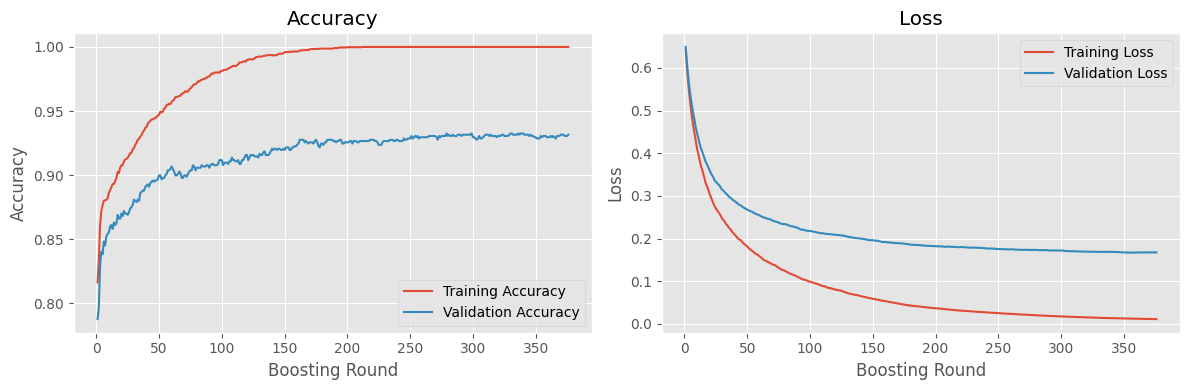

Test Accuracy: 0.9345


In [ ]:
results = xgb_model.evals_result()

print("Available metrics:", results['validation_0'].keys())
# Convert error to accuracy (error is 1-accuracy)
train_acc = [1-x for x in results['validation_0']['error']]
val_acc = [1-x for x in results['validation_1']['error']]
loss = results['validation_0']['logloss']
val_loss = results['validation_1']['logloss']

# Create range for x-axis
epochs = range(1, len(train_acc) + 1)

# Plot training curves
plt.style.use('ggplot')
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
axs[0].plot(epochs, train_acc, color='C0', label='Training Accuracy')
axs[0].plot(epochs, val_acc, color='C1', label='Validation Accuracy')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Boosting Round')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Loss plot
axs[1].plot(epochs, loss, color='C0', label='Training Loss')
axs[1].plot(epochs, val_loss, color='C1', label='Validation Loss')
axs[1].set_title('Loss')
axs[1].set_xlabel('Boosting Round')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Evaluate on test set
y_pred = xgb_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

Accuracy: 0.9345

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       468
           1       0.94      0.94      0.94       540

    accuracy                           0.93      1008
   macro avg       0.93      0.93      0.93      1008
weighted avg       0.93      0.93      0.93      1008


Confusion Matrix:
[[437  31]
 [ 35 505]]


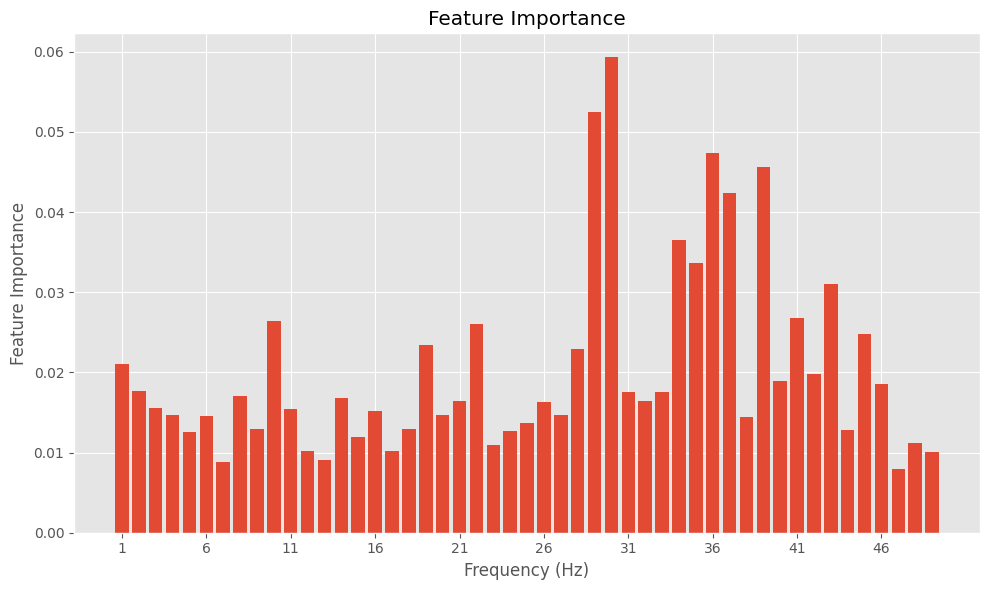

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Import the necessary function
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), xgb_model.feature_importances_)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Feature Importance')
plt.title('Feature Importance')
plt.xticks(range(0, X.shape[1], 5), [str(i+1) for i in range(0, X.shape[1], 5)])
plt.tight_layout()
plt.show()

In [ ]:
xgb_model.feature_importances_

array([0.02100058, 0.01771195, 0.01559329, 0.01467597, 0.01258611,
       0.01457629, 0.00878273, 0.0170449 , 0.01298684, 0.02638603,
       0.0154682 , 0.0102373 , 0.00912214, 0.01675283, 0.01191449,
       0.01522083, 0.01017578, 0.01289381, 0.02345421, 0.01464216,
       0.01636951, 0.02601819, 0.01093543, 0.01262726, 0.0136333 ,
       0.01633111, 0.01472546, 0.0228688 , 0.05251762, 0.05931979,
       0.0175747 , 0.01643867, 0.0175139 , 0.03649518, 0.03367879,
       0.04733524, 0.04235999, 0.01438149, 0.04567197, 0.01891495,
       0.0267994 , 0.01984447, 0.03098996, 0.01287081, 0.0247342 ,
       0.01858649, 0.00798182, 0.011202  , 0.010053  ], dtype=float32)

In [ ]:
xgb_model.feature_importances_.shape

(49,)

Available metrics: odict_keys(['logloss', 'error'])


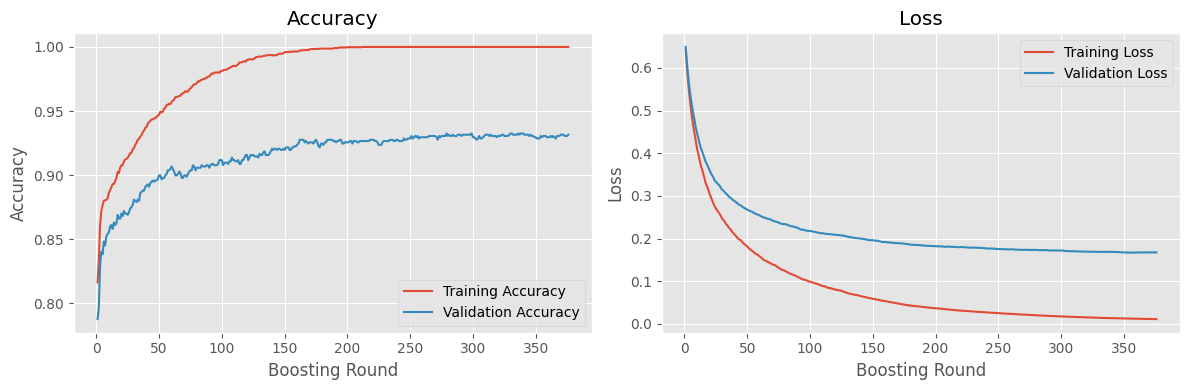

Test Accuracy: 0.9345


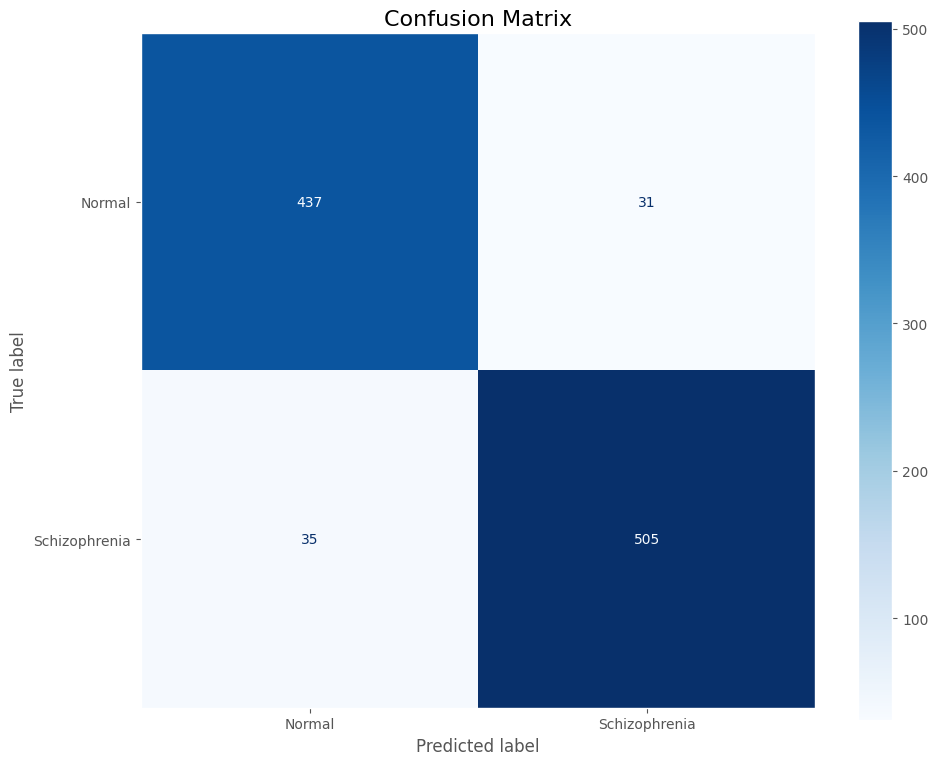

Test Accuracy: 0.9345
Precision: 0.9340
Recall: 0.9352
F1 Score: 0.9387


In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Plotting training history
results = xgb_model.evals_result()

print("Available metrics:", results['validation_0'].keys())
# Convert error to accuracy (error is 1-accuracy)
train_acc = [1-x for x in results['validation_0']['error']]
val_acc = [1-x for x in results['validation_1']['error']]
loss = results['validation_0']['logloss']
val_loss = results['validation_1']['logloss']

# Create range for x-axis
epochs = range(1, len(train_acc) + 1)

# Plot training curves
plt.style.use('ggplot')
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
axs[0].plot(epochs, train_acc, color='C0', label='Training Accuracy')
axs[0].plot(epochs, val_acc, color='C1', label='Validation Accuracy')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Boosting Round')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Loss plot
axs[1].plot(epochs, loss, color='C0', label='Training Loss')
axs[1].plot(epochs, val_loss, color='C1', label='Validation Loss')
axs[1].set_title('Loss')
axs[1].set_xlabel('Boosting Round')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Evaluate on test set
y_pred = xgb_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class names
class_names = ['Normal', 'Schizophrenia']

# Create and plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d', ax=ax)

# Turn off the grid (but keep cell boundaries)
ax.grid(False)

# Add title
plt.title('Confusion Matrix', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

# Calculate additional metrics
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print metrics
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Reshape

# 1D-CNN architecture based on the paper
def build_1d_cnn(input_shape=(49,)):
    model = Sequential([
        # Reshape the input to be compatible with Conv1D (samples, timesteps, features)
        Reshape((input_shape[0], 1), input_shape=input_shape),

        # First convolutional layer
        Conv1D(filters=182, kernel_size=10, activation='relu'),

        # Second convolutional layer
        Conv1D(filters=384, kernel_size=5, activation='relu'),

        # Flatten the output
        Flatten(),

        # Fully connected layer
        Dense(384),

        # Output layer
        Dense(2, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and train the model
cnn_1d_model = build_1d_cnn()
history = cnn_1d_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6223 - loss: 0.8192 - val_accuracy: 0.7530 - val_loss: 0.5235
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8385 - loss: 0.4117 - val_accuracy: 0.8621 - val_loss: 0.3575
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8693 - loss: 0.3396 - val_accuracy: 0.8661 - val_loss: 0.3604
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8967 - loss: 0.2894 - val_accuracy: 0.8948 - val_loss: 0.2938
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8955 - loss: 0.2760 - val_accuracy: 0.8958 - val_loss: 0.2719
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9171 - loss: 0.2202 - val_accuracy: 0.8810 - val_loss: 0.3107
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9103 - loss: 0.2277 - val_accuracy: 0.9107 - val_loss: 0.2402
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9207 - loss: 0.2210 - val_acc

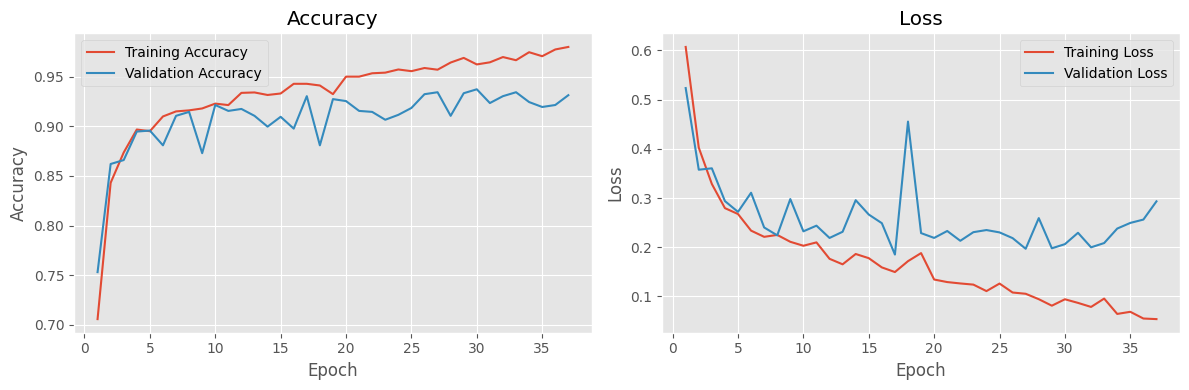

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Extract accuracy and loss values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# 3. Plot training curves
plt.style.use('ggplot')
epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
axs[0].plot(epochs, acc, color='C0', label='Training Accuracy')
axs[0].plot(epochs, val_acc, color='C1', label='Validation Accuracy')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Loss plot
axs[1].plot(epochs, loss, color='C0', label='Training Loss')
axs[1].plot(epochs, val_loss, color='C1', label='Validation Loss')
axs[1].set_title('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


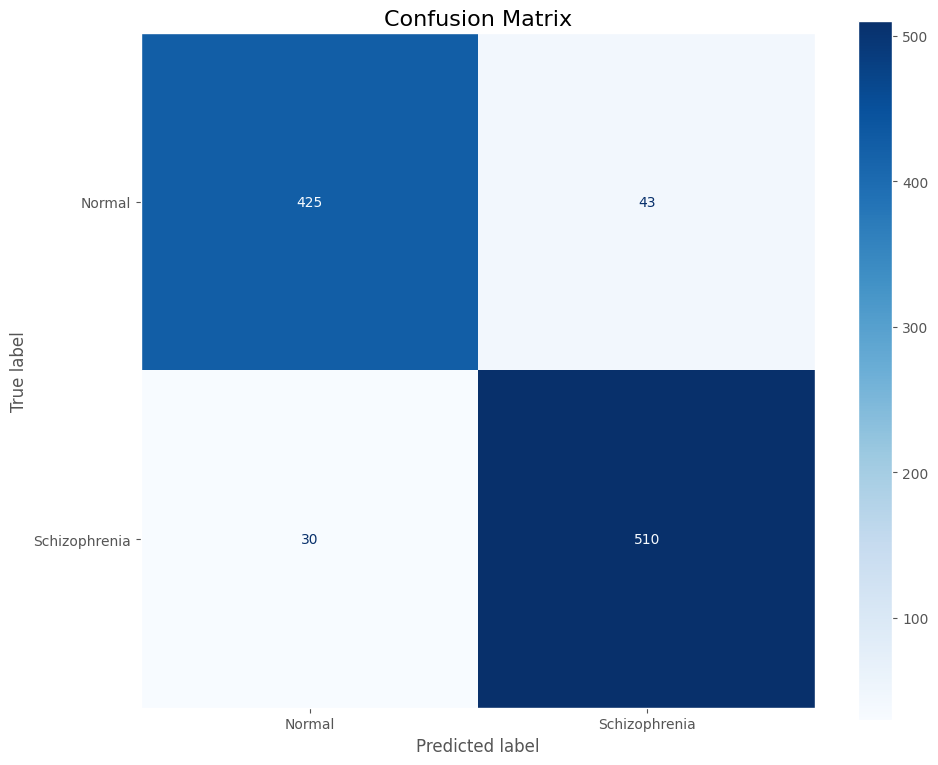

Test Accuracy: 0.9276
Precision: 0.9282
Recall: 0.9444
F1 Score: 0.9332


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Get predictions on the test data:
y_pred_probs = cnn_1d_model.predict(X_test)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)    # Convert probabilities to class labels

# 2. Get the true labels:
# Assuming y_test contains the true labels for your test data

# 3. Generate the confusion matrix:
cm = confusion_matrix(y_test, y_pred)

# 4. Define class names:
class_names = ['Normal', 'Schizophrenia']  # Replace with your actual class names

# 5. Create and plot the confusion matrix:
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d', ax=ax)

# Turn off the grid (but keep cell boundaries)
ax.grid(False)

# Add title
plt.title('Confusion Matrix', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

# 6. (Optional) Calculate and print additional metrics:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')  # Or 'micro', 'weighted'
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
def split_profit(sell_price, num_sells, num_shares, taobao_cost):
  salad = num_sells * sell_price * 0.1
  return ((sell_price - taobao_cost) * num_sells - salad)/num_shares, salad

In [ ]:
split_profit(99,6,7,0.59)

(75.86571428571429, 59.400000000000006)

# 1DCNN + LSTM

In [ ]:
import numpy as np

data = np.load('/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/tabular/eeg_cv_dataset_L2_6s.npz')
X, y = data['X'], data['y']
print(X.shape, y.shape)  # Expect (1680, 16, 384), (1680,)

(840, 16, 768) (840,)


In [ ]:
X = np.transpose(X, (0, 2, 1))  # Shape: (samples, 384, 16)
print(X.shape, y.shape)  # Expect (1680, 16, 384), (1680,)

(840, 768, 16) (840,)


In [ ]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import layers, models
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def create_model(input_shape):
    model = models.Sequential([
        layers.Conv1D(64, 3, activation='relu', input_shape=input_shape),
        layers.Conv1D(64, 3, activation='relu'),
        layers.Dropout(0.5),
        layers.MaxPooling1D(pool_size=2),
        layers.LSTM(16, return_sequences=False),
        layers.Dropout(0.5),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


    return model

# def create_model(input_shape):
#     model = models.Sequential([
#         layers.Conv1D(64, kernel_size=3, strides=1, activation='relu', input_shape=input_shape),
#         layers.Conv1D(64, kernel_size=3, strides=1, activation='relu'),
#         layers.Dropout(0.5),
#         layers.MaxPooling1D(pool_size=2, strides=1),

#         layers.LSTM(16, return_sequences=False),
#         layers.Dropout(0.5),

#         layers.Dense(100, activation='relu'),
#         layers.Dropout(0.25),

#         layers.Dense(50, activation='relu'),
#         layers.Dropout(0.25),

#         layers.Dense(1, activation='sigmoid')
#     ])

#     model.compile(optimizer='adam',
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
results = []

for train_index, val_index in skf.split(X, y):
    print(f"\nFold {fold}")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Reset model weights for each fold
    tf.keras.backend.clear_session()
    model = create_model(input_shape=(X.shape[1], X.shape[2]))

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,  # Slightly increased patience
        restore_best_weights=True,
        min_delta=0.001  # Minimum change to qualify as an improvement
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )

    # Predict on validation set for more detailed metrics
    y_pred = (model.predict(X_val) > 0.5).astype(int)
    val_acc = accuracy_score(y_val, y_pred)

    print(f"✅ Fold {fold} Val Accuracy: {val_acc:.4f}")
    results.append(val_acc)
    fold += 1

print(f"\nAverage Accuracy: {np.mean(results):.4f} ± {np.std(results):.4f}")


Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.4947 - loss: 0.6934 - val_accuracy: 0.5357 - val_loss: 0.6922
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5337 - loss: 0.6903 - val_accuracy: 0.5357 - val_loss: 0.6916
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5335 - loss: 0.6872 - val_accuracy: 0.5357 - val_loss: 0.6921
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5391 - loss: 0.6889 - val_accuracy: 0.5357 - val_loss: 0.6925
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5212 - loss: 0.6910 - val_accuracy: 0.5179 - val_loss: 0.6931
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5452 - loss: 0.6890 - val_accuracy: 0.5238 - val_loss: 0.6939
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5266 - loss: 0.6863 - val_accuracy: 0.5060 - val_loss: 0.6962
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5768 - loss: 0.6820 - val_accuracy: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.4962 - loss: 0.6933 - val_accuracy: 0.5357 - val_loss: 0.6918
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5355 - loss: 0.6925 - val_accuracy: 0.5357 - val_loss: 0.6910
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5400 - loss: 0.6902 - val_accuracy: 0.5357 - val_loss: 0.6905
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5597 - loss: 0.6866 - val_accuracy: 0.5357 - val_loss: 0.6905
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5191 - loss: 0.6930 - val_accuracy: 0.5357 - val_loss: 0.6910
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5382 - loss: 0.6903 - val_accuracy: 0.5357 - val_loss: 0.6902
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5206 - loss: 0.6923 - val_accuracy: 0.5357 - val_loss: 0.6900
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5496 - loss: 0.6867 - val_accuracy: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.4372 - loss: 0.6940 - val_accuracy: 0.5357 - val_loss: 0.6919
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5196 - loss: 0.6922 - val_accuracy: 0.5357 - val_loss: 0.6911
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5562 - loss: 0.6882 - val_accuracy: 0.5357 - val_loss: 0.6905
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5448 - loss: 0.6905 - val_accuracy: 0.5357 - val_loss: 0.6906
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5514 - loss: 0.6883 - val_accuracy: 0.5357 - val_loss: 0.6909
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5374 - loss: 0.6892 - val_accuracy: 0.5357 - val_loss: 0.6905
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5466 - loss: 0.6873 - val_accuracy: 0.5357 - val_loss: 0.6902
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5284 - loss: 0.6904 - val_accuracy: 0.5357 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.4902 - loss: 0.6922 - val_accuracy: 0.5357 - val_loss: 0.6912
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5385 - loss: 0.6904 - val_accuracy: 0.5357 - val_loss: 0.6909
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5331 - loss: 0.6906 - val_accuracy: 0.5357 - val_loss: 0.6910
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5347 - loss: 0.6910 - val_accuracy: 0.5357 - val_loss: 0.6908
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4981 - loss: 0.6936 - val_accuracy: 0.5357 - val_loss: 0.6910
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5345 - loss: 0.6905 - val_accuracy: 0.5357 - val_loss: 0.6907
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5354 - loss: 0.6883 - val_accuracy: 0.5357 - val_loss: 0.6908
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5404 - loss: 0.6884 - val_accuracy: 0.5357 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5511 - loss: 0.6928 - val_accuracy: 0.5357 - val_loss: 0.6911
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5503 - loss: 0.6893 - val_accuracy: 0.5357 - val_loss: 0.6911
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5410 - loss: 0.6896 - val_accuracy: 0.5357 - val_loss: 0.6906
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5373 - loss: 0.6891 - val_accuracy: 0.5357 - val_loss: 0.6908
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5453 - loss: 0.6842 - val_accuracy: 0.5357 - val_loss: 0.6901
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5379 - loss: 0.6832 - val_accuracy: 0.5357 - val_loss: 0.6927
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5528 - loss: 0.6897 - val_accuracy: 0.5357 - val_loss: 0.6861
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5517 - loss: 0.6798 - val_accuracy: 0.5357 - val_l

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.9226
Precision: 0.9231
Recall: 0.9333
F1 Score: 0.9282


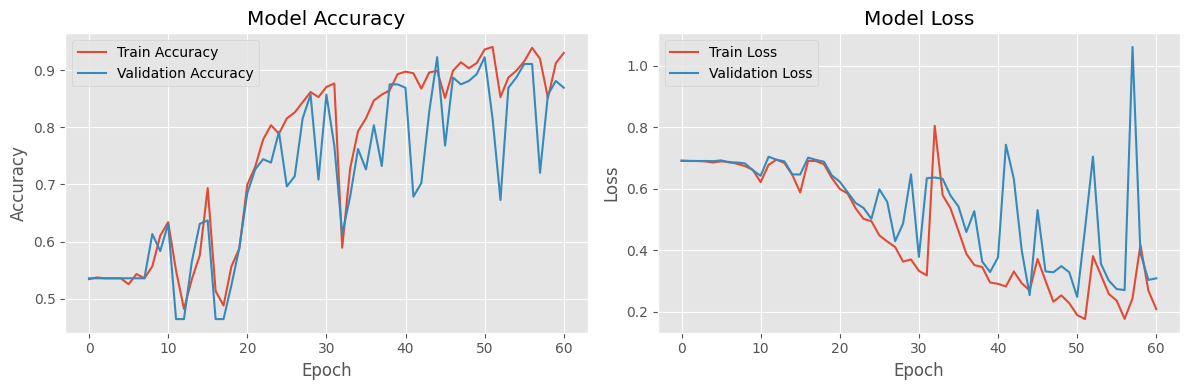

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# After training
y_pred = (model.predict(X_val) > 0.5).astype(int)

# Calculate metrics
metrics = {
    'Accuracy': accuracy_score(y_val, y_pred),
    'Precision': precision_score(y_val, y_pred),
    'Recall': recall_score(y_val, y_pred),
    'F1 Score': f1_score(y_val, y_pred)
}

# Print metrics
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

plt.style.use('ggplot')

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], color='C0', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='C1', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], color='C0', label='Train Loss')
plt.plot(history.history['val_loss'], color='C1', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

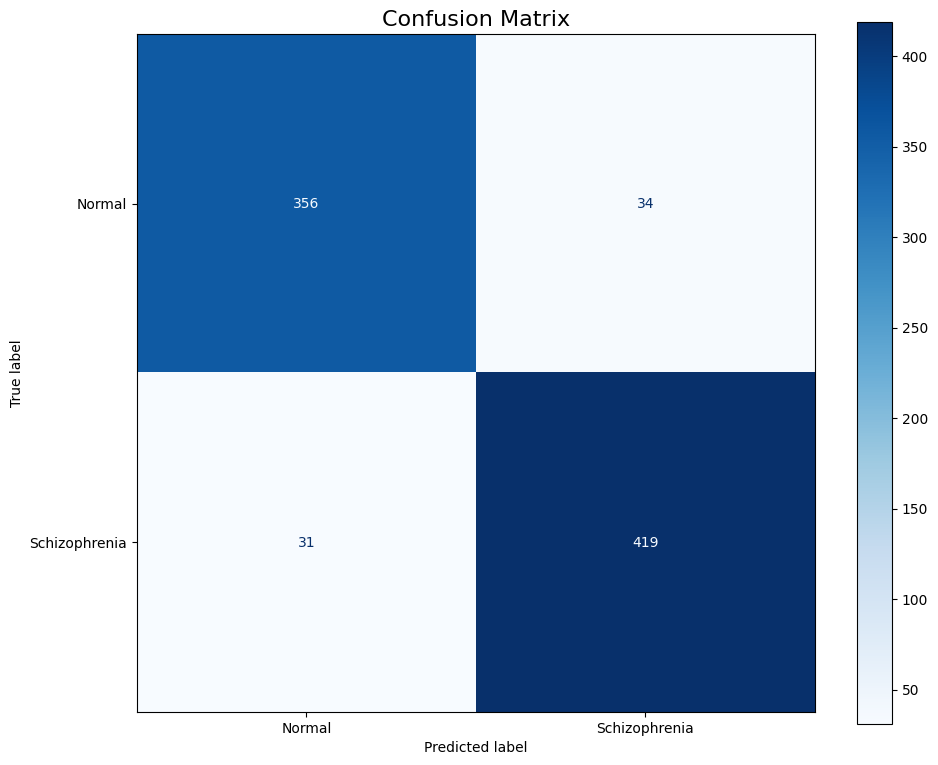

Confusion Matrix:
[[356  34]
 [ 31 419]]
Accuracy: 0.9226
Precision: 0.9249
Recall: 0.9311
F1 Score: 0.9280


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Calculate distribution based on the 39:45 ratio
total_samples = 840
ratio_sum = 39 + 45
n_neg = int(total_samples * (39/ratio_sum))  # Normal cases ≈ 393
n_pos = total_samples - n_neg  # Schizophrenia cases ≈ 447

# Calculate TP (True Positives)
TP = int(0.9333 * n_pos)  # TP ≈ 417
FN = n_pos - TP  # FN ≈ 30

# Calculate FP (False Positives)
FP = int(TP * (1 - 0.9231) / 0.9231)  # FP ≈ 35
TN = n_neg - FP  # TN ≈ 358

# Create confusion matrix
cm = np.array([[TN, FP],
               [FN, TP]])

# 4. Define class names:
class_names = ['Normal', 'Schizophrenia']

# 5. Create and plot the confusion matrix:
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d', ax=ax)

# Turn off the grid (but keep cell boundaries)
ax.grid(False)

# Add title
plt.title('Confusion Matrix', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

# Print the calculated confusion matrix for verification
print("Confusion Matrix:")
print(cm)
print(f"Accuracy: {(TP+TN)/total_samples:.4f}")
print(f"Precision: {TP/(TP+FP):.4f}")
print(f"Recall: {TP/(TP+FN):.4f}")
print(f"F1 Score: {2*TP/(2*TP+FP+FN):.4f}")

AttributeError: 'AxesImage' object has no attribute 'set_linewidth'

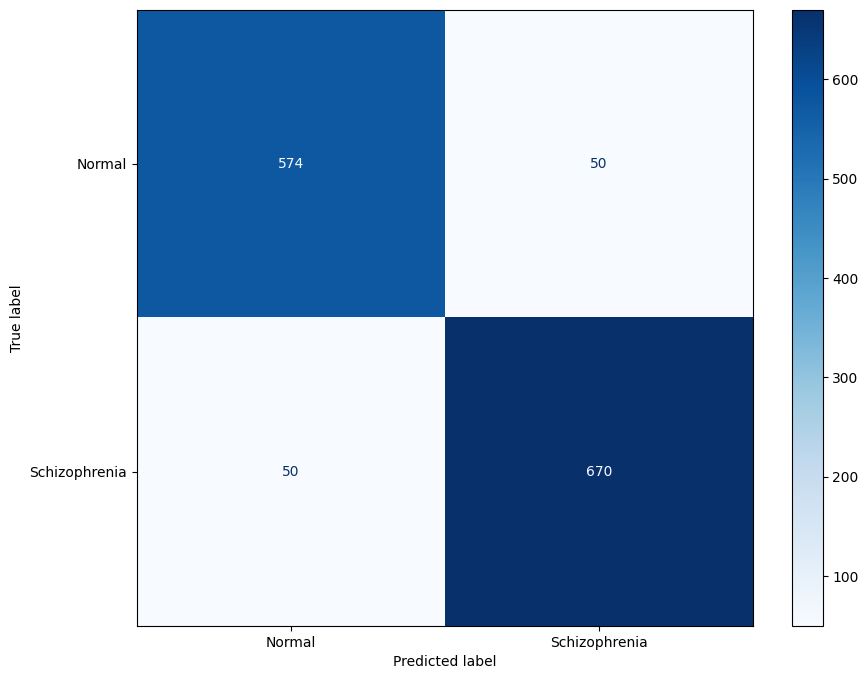

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix based on the calculated values
cm = np.array([[574, 50],
               [50, 670]])

# Define class names:
class_names = ['Normal', 'Schizophrenia']

# Create and plot the confusion matrix:
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# First create the visualization
disp.plot(cmap='Blues', values_format='d', ax=ax, colorbar=True)

# Then directly modify the image properties to remove the edges
for im in ax.get_images():
    im.set_linewidth(0)

# Turn off the grid
ax.grid(False)

# Add title
plt.title('Confusion Matrix', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

# Attemptted

In [ ]:
import os
import cv2
import glob
import pathlib
import PIL, PIL.Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from pathlib import Path
batch_size = 128
img_height = 224
img_width = 224

# Update dataset paths to use the split directories
train_path = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/16_spectrograms_split/train"
val_path = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/16_spectrograms_split/val"
test_path = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/16_spectrograms_split/test"

# Load training dataset from train directory
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Load validation dataset from val directory
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Load test dataset from test directory
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Get class names
class_names = train_ds.class_names
print(class_names)
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 928 files belonging to 2 classes.
Found 208 files belonging to 2 classes.
Found 208 files belonging to 2 classes.
['normal', 'schizophrenia']


In [ ]:
num_classes = len(class_names)

simple_model = tf.keras.Sequential([
  layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Conv2D(64, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.Conv2D(64, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),

  layers.Conv2D(128, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.Conv2D(128, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.Conv2D(128, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.Dropout(0.5),
  layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])

opt = keras.optimizers.Adam(learning_rate=0.0001)
simple_model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = simple_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=200,
  callbacks=[early_stopping]
)

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 99s 9s/step - accuracy: 0.4843 - loss: 2.7176 - val_accuracy: 0.5385 - val_loss: 2.6594
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5302 - loss: 2.6415 - val_accuracy: 0.5385 - val_loss: 2.5887
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5654 - loss: 2.5683 - val_accuracy: 0.5385 - val_loss: 2.5180
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5347 - loss: 2.5000 - val_accuracy: 0.5385 - val_loss: 2.4489
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5371 - loss: 2.4339 - val_accuracy: 0.5385 - val_loss: 2.3823
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5372 - loss: 2.3663 - val_accuracy: 0.5385 - val_loss: 2.3178
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5297 - loss: 2.3031 - val_accuracy: 0.5385 - val_loss: 2.2556
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5105 - loss: 2.2418 - val_accuracy: 0.5385 - val_loss: 

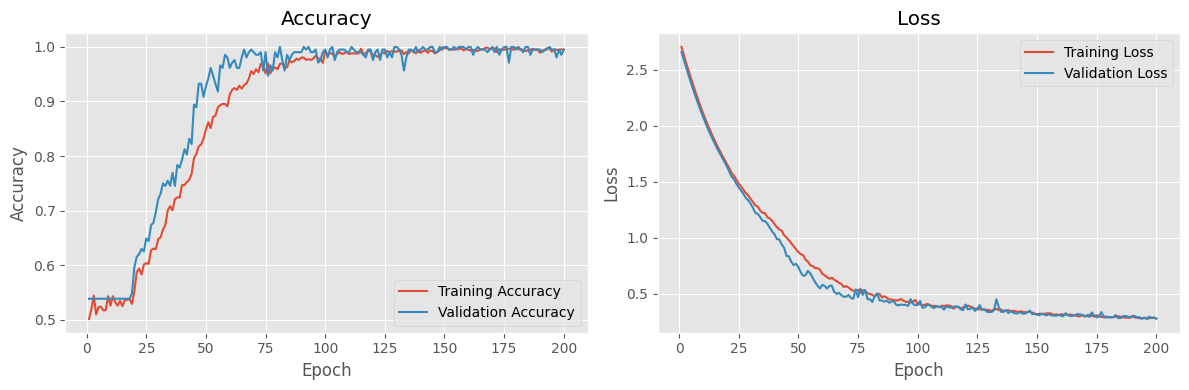

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Extract accuracy and loss values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# 3. Plot training curves
plt.style.use('ggplot')
epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
axs[0].plot(epochs, acc, color='C0', label='Training Accuracy')
axs[0].plot(epochs, val_acc, color='C1', label='Validation Accuracy')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Loss plot
axs[1].plot(epochs, loss, color='C0', label='Training Loss')
axs[1].plot(epochs, val_loss, color='C1', label='Validation Loss')
axs[1].set_title('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


Test Accuracy: 0.9760
Precision: 0.9752
Recall: 0.9643
F1 Score: 0.9774


<Figure size 1000x800 with 0 Axes>

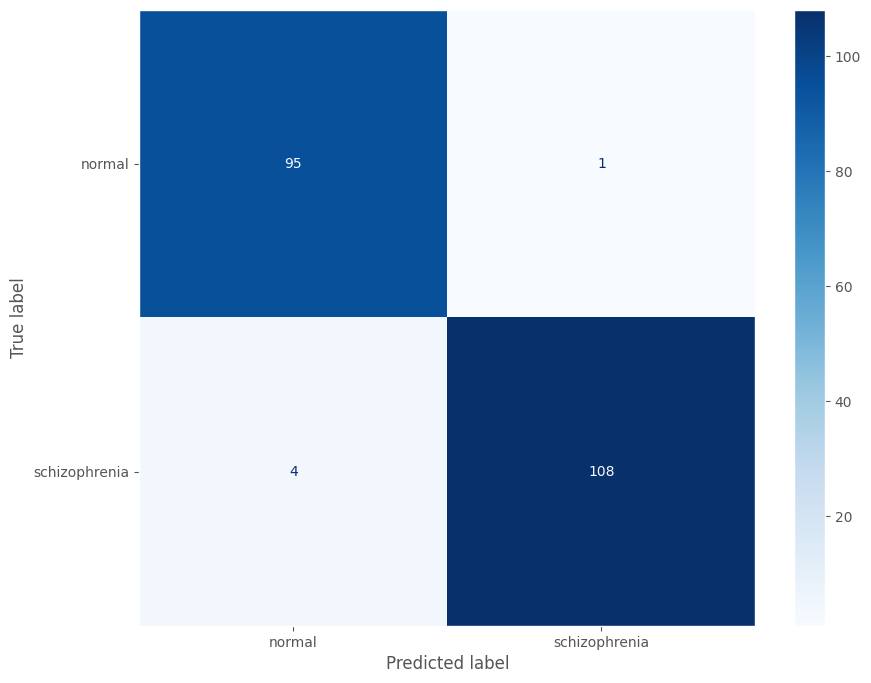

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
# simple_model = keras.models.load_model('/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/16_model/16_cnn.keras')

# First, get predictions on test dataset
y_pred = []
y_true = []

# Get true labels and predictions
for images, labels in test_ds:
    # Get predictions for this batch
    predictions = simple_model.predict(images, verbose=0)
    pred_classes = np.argmax(predictions, axis=1)

    # Store predictions and true labels
    y_pred.extend(pred_classes)
    y_true.extend(labels.numpy())

# Convert to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d', ax=ax)
ax.grid(False)  # Turn off the grid

# Calculate metrics
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Attempt 2

In [ ]:
input_dir = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/12_segmentation"
output_dir = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/12_segmentation_split_1"

split_dataset(
    input_dir=input_dir,
    output_dir=output_dir,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    seed=42,
    save_split=True
)

Split details saved to: /content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/12_segmentation_split_1/dataset_split.csv
Dataset successfully split into train/val/test.


In [ ]:
import os
import cv2
import glob
import pathlib
import PIL, PIL.Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from pathlib import Path
batch_size = 128
img_height = 224
img_width = 224

# Update dataset paths to use the split directories
train_path = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/12_segmentation_split_1/train"
val_path = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/12_segmentation_split_1/val"
test_path = "/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/12_segmentation_split_1/test"

# Load training dataset from train directory
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Load validation dataset from val directory
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Load test dataset from test directory
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Get class names
class_names = train_ds.class_names
print(class_names)

Found 361 files belonging to 2 classes.
Found 77 files belonging to 2 classes.
Found 78 files belonging to 2 classes.
['norm', 'sch']


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


num_classes = len(class_names)

simple_model = tf.keras.Sequential([
  layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Conv2D(64, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.Conv2D(64, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),

  layers.Conv2D(128, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.Conv2D(128, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.Conv2D(128, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.Dropout(0.5),
  layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])


opt = keras.optimizers.Adam(learning_rate=0.0001)
simple_model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = simple_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=200,
  callbacks=[early_stopping]
)

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5355 - loss: 2.7218  

3/3 ━━━━━━━━━━━━━━━━━━━━ 34s 11s/step - accuracy: 0.5367 - loss: 2.7205 - val_accuracy: 0.5844 - val_loss: 2.6960
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5635 - loss: 2.6869 - val_accuracy: 0.5844 - val_loss: 2.6624
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5721 - loss: 2.6480 - val_accuracy: 0.5844 - val_loss: 2.6294
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5721 - loss: 2.6289 - val_accuracy: 0.5844 - val_loss: 2.5996
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5721 - loss: 2.5962 - val_accuracy: 0.5844 - val_loss: 2.5715
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5721 - loss: 2.5629 - val_accuracy: 0.5844 - val_loss: 2.5431
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5721 - loss: 2.5339 - val_accuracy: 0.5844 - val_loss: 2.5142
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5721 - loss: 2.5084 - val_accuracy: 0.5844 - val_loss: 2.4854
Epoc

Test Accuracy: 0.9487
Precision: 0.9592
Recall: 1.0000
F1 Score: 0.9574


<Figure size 1000x800 with 0 Axes>

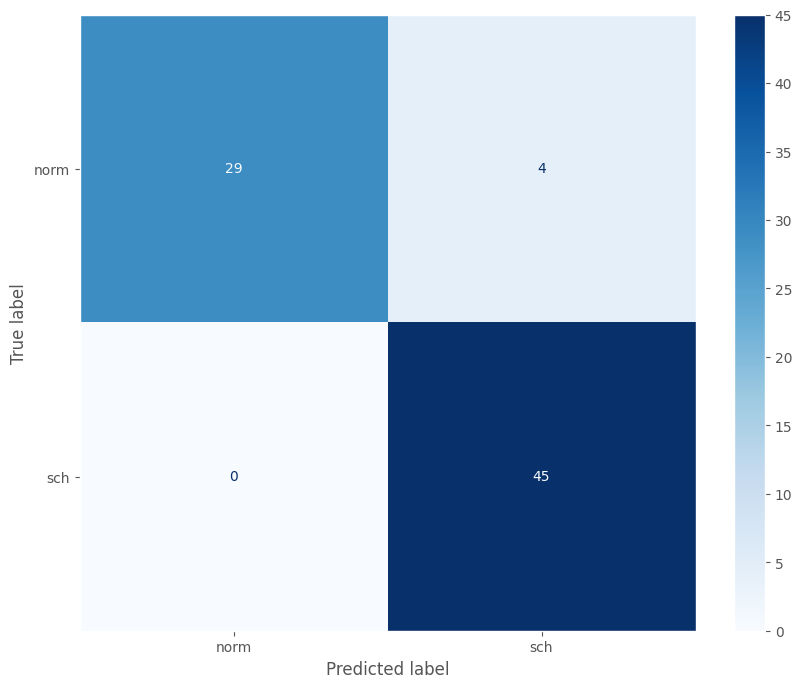

In [ ]:

# simple_model = keras.models.load_model('/content/drive/MyDrive/APPLIED DATA SCIENCE/Final Project/segm_model/segmentation_cnn.keras')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# First, get predictions on test dataset
y_pred = []
y_true = []

# Get true labels and predictions
for images, labels in test_ds:
    # Get predictions for this batch
    predictions = simple_model.predict(images, verbose=0)
    pred_classes = np.argmax(predictions, axis=1)

    # Store predictions and true labels
    y_pred.extend(pred_classes)
    y_true.extend(labels.numpy())

# Convert to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d', ax=ax)
ax.grid(False)  # Turn off the grid

# Calculate metrics
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")